In [ ]:
%pip install langchain-openai langchain langchain-core --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.5/973.5 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.5/308.5 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.6/320.6 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.8/122.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.3 MB/s eta 0:00:00


# Experiment 5

Games: Ultimatum Game, Dictator Game, and Endowment Game

Models: GPT-3.5

This experiment runs the profile generator and chosen games for each model. We test both models for generating the profiles, and then each game is run with each model for a fixed set of profiles. This yields two sets of profiles and four sets of game results.

This notebook contains code for running the selected games with GPT-3.5-turbo, for both sets of profiles generated in Experiment 5 - Profiles.

In [ ]:
# load the profiles
import os
import json

os.environ['OPENAI_API_KEY'] = ""

In [ ]:
with open("/content/profiles_Claude3.json", "r") as f:
    claude3_profiles = json.load(f)

with open("/content/profiles_GPT4o.json", "r") as f:
    GPT4o_profiles = json.load(f)

### utils

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List, Optional

def compute_cost(tokens, engine):
    """Computes a proxy for the cost of a response based on the number of tokens generated (i.e, cos of output) and the engine used"""
    model_prices = {"gpt-3.5-turbo": 1}

    model_price = model_prices[engine]

    cost = (tokens / 1_000_000) * model_price

    return cost

def load_llm(provider='gpt-3.5-turbo',
             temperature=1,
             max_tokens=55,
             profile=None):
    """
    Loads a language model based on the specified provider.

    Parameters:
    - provider (str, optional): The LLM provider and version. Default is 'openai-3.5-turbo'.
    - temperature (float, optional): The generation temperature for the LLM. Default is 0.75.
    - max_tokens (int, optional): The maximum token limit for LLM responses. Default is 55.
    - profile (str, optional): The cultural profile to build system prompt. Default is no system prompt (vainilla LLM behavior)

    Returns:
    - ChatOpenAI: An instance of the LangChain object ChatOpenAI.

    Raises:
    - ValueError: If an unsupported provider is specified.
    """
    supported_providers = ['gpt-3.5-turbo']

    if provider not in supported_providers:
        raise ValueError(f"Unsupported provider. Supported providers are: {', '.join(supported_providers)}")

    llm = ChatOpenAI(model=provider,
                    temperature=temperature,
                    max_tokens=max_tokens)

    return llm

In [ ]:
import asyncio
from concurrent.futures import ThreadPoolExecutor
import json
import pandas as pd
import time

def count_responses(response, prefix=""):
    """
    Counts occurrences of "yes" and "no" keywords in a collection of responses.

    Parameters:
    - response (str): The textual response to analyze.
    - prefix (str): Optional prefix for keys in the returned dictionary.

    Returns:
    - dict: A dictionary containing counts of "yes" and "no" occurrences.
    """
    accept_count = reject_count = ambiguous_count = 0

    string_lower = response.lower()
    if 'no' in string_lower:
        reject_count += 1
    elif 'yes' in string_lower:
        accept_count += 1
    else:
        ambiguous_count += 1  # Count as ambiguous if neither explicitly accepted nor rejected

    # Prefix keys if a prefix is provided
    keys = ["Accept Count", "Reject Count", "Ambiguous Count"]
    if prefix:
        keys = [f"{prefix} {key}" for key in keys]

    return {
        keys[0]: accept_count,
        keys[1]: reject_count,
        keys[2]: ambiguous_count,
    }

In [ ]:
ACHE = claude3_profiles['claude-3-opus-20240229']['Aché']
HAZDA = claude3_profiles['claude-3-opus-20240229']['Hazda']
TSIMANE = claude3_profiles['claude-3-opus-20240229']['Tsimane']
ORMA = claude3_profiles['claude-3-opus-20240229']['Orma']
YANOMAMI = claude3_profiles['claude-3-opus-20240229']['Yanomami']
MACHIGUENGA = claude3_profiles['claude-3-opus-20240229']['Machiguenga']

## Uncomment to run code with GPT-4o generated profiles ##
### Comment the lines above

#ACHE = GPT4o_profiles['gpt-4o-2024-05-13']['Aché']
#HAZDA = GPT4o_profiles['gpt-4o-2024-05-13']['Hazda']
#TSIMANE = GPT4o_profiles['gpt-4o-2024-05-13']['Tsimane']
#ORMA = GPT4o_profiles['gpt-4o-2024-05-13']['Orma']
#YANOMAMI = GPT4o_profiles['gpt-4o-2024-05-13']['Yanomami']
#MACHIGUENGA = GPT4o_profiles['gpt-4o-2024-05-13']['Machiguenga']

profiles = [ACHE, HAZDA, TSIMANE, ORMA, YANOMAMI, MACHIGUENGA, ""]
NAMES = ["Ache", "Hadza", "Tsimane", "Orma", "Yanomami", "Machiguenga", "GPT3"]

## Dictator Game

- 1 Agent: Dictator
    - The Dictator is endowed a fixed amount of the good (day's worth of work ($10$)), and asked if it would accept or reject that split.

    - The Dicator replies "yes" or "no"

    - The experiment consists of varying $x$ and recording the LLM responses. The number of yes and no are aggregated with regular expression by counting the number of times "no" and "yes" are recorded in the responses (once per response). For each value of $x$ we run 100 experiments. We plot the average number of counts for each split.

In [ ]:
import asyncio
from concurrent.futures import ThreadPoolExecutor

import json
import pandas as pd
import time

async def simulate_offer_responses_async(executor, llm, profile, amount_endowed, offer_amount):
    loop = asyncio.get_event_loop()

    dictator_prompt = generate_prompt(profile, amount_endowed, offer_amount)

    # Run the synchronous .invoke method in a thread pool
    dictator_response = await loop.run_in_executor(executor, llm.invoke, dictator_prompt)

    return dictator_response.content

async def run_experiment(executor, llm, profile, amount_endowed, offer_amounts, num_runs):
    start_time = time.time()
    organized_results = {amount: [] for amount in offer_amounts}

    for offer_amount in offer_amounts:
        responses = await simulate_and_collect_responses(executor, llm, profile, amount_endowed, offer_amount, num_runs)
        organized_results[offer_amount].extend(responses)

    elapsed_time = time.time() - start_time
    print(f"Experiment completed in {elapsed_time:.2f} seconds.")

    return organized_results

async def simulate_and_collect_responses(executor, llm, profile, amount_endowed, offer_amount, num_runs):
    tasks = [simulate_offer_responses_async(executor, llm, profile, amount_endowed, offer_amount) for _ in range(num_runs)]

    responses = await asyncio.gather(*tasks)
    return responses

In [ ]:
def post_experiment_processing(organized_results,
                               engine,
                               game="DG",
                               tribename=""):
    total_costs = []
    all_data = []

    for offer_amount, responses in organized_results.items():
        for dictator_response in responses:
            game_cost = compute_cost(len(dictator_response.split()), engine)
            total_costs.append(game_cost)

            dictator_counts = count_responses(dictator_response, prefix="Dictator")

            data_entry = {
                'Offer Amount': offer_amount,
                **dictator_counts,
            }
            all_data.append(data_entry)

    experiment_cost = sum(total_costs)
    print(f"Total Experiment Cost: {experiment_cost}")

    # Save responses to file
    with open(f"/content/Responses/{tribename}-{game}.json", "w") as file:
        json.dump(organized_results, file)

    return pd.DataFrame(all_data), experiment_cost


In [ ]:
import seaborn as sns

def heatmap_responses(results_df):
    """
    Creates a heatmap showing the frequency of accept, reject, and ambiguous responses for each offer amount.

    Parameters:
    - results_df (pandas.DataFrame): DataFrame containing the detailed experiment results per run.
    """
    # Create a summary table with counts of each response type for each offer amount
    summary_table = results_df.groupby('Offer Amount').sum()

    plt.figure(figsize=(10, 6))
    sns.heatmap(summary_table, annot=True, cmap="YlGnBu", fmt='d')
    plt.title('Heatmap of Response Counts by Offer Amount')
    plt.xlabel('Offer Amount ($)')
    plt.ylabel('Response Type')
    plt.show()


In [ ]:
from typing import Tuple, Dict, List, Optional

def generate_prompt(profile: str = "",
                    amount_endowed: int = 10,
                    offer_amount: int = None) -> str:
    """
    Generates a prompt for the dictator game where an experimenter proposes a specific split of an endowed amount,
    and the dictator (agent) decides whether to accept or reject the proposed split.

    :param profile: A string description that could describe the characteristics of a hypothetical dictator.
    :param amount_endowed: The total amount endowed to the dictator.
    :param offer_amount: The specific amount proposed to be given to another participant.
    :return: A string containing the generated prompt.
    """

    system_prompt = ""

    if len(profile) > 10:
        system_prompt = f"""You are a member of a tribe with the following characteristics.
                You must answer as if you were a representative member of such tribe.

                -----
                {profile}

                -----

                You have been selected to participate in an economic experiment.
            """
    else:
        system_prompt = "You are an assistant that has been selected to participate in an economic experiment."

    game_instructions = (f"In this experiment, you are endowed with ${amount_endowed}, which represents a day's worth of work. "
                         f"An experimenter proposes that you give at most ${offer_amount} of this endowment to another {'tribe member' if len(profile) > 10 else 'player'} whose identity is not disclosed, " # first prompt had another anonymous participant
                         f"leaving you with ${amount_endowed - offer_amount} for yourself. "
                         "An offer of 5 means equal split. "
                         f"Do you accept this distribution? Please answer 'Yes' or 'No'.\n"
                         "Start with your answer, followed by a separator token [EXP], and then briefly justify your reasoning step by step.")

    return system_prompt + "\n\n\n" + game_instructions

In [ ]:
async def DG_main(profile, game, tribename):
    '''
    Run 100 experiments of the dictator game for each offer amount
    '''
    executor = ThreadPoolExecutor()
    engine = "gpt-3.5-turbo"
    llm = load_llm(engine, profile=profile)

    amount_endowed = 10  # day's worth of work
    offer_amounts = list(range(0, 11))  # Amounts in dollars to experiment with

    organized_results = await run_experiment(
        executor=executor,
        llm=llm,
        profile=profile,
        amount_endowed=amount_endowed,
        offer_amounts=offer_amounts,
        num_runs=100
    )

    df, cost = post_experiment_processing(organized_results, engine, game, tribename)
    return df, cost


In [ ]:
# hazda responder mostly reject
results_df, cost = await DG_main(ACHE,
                                 game="DG",
                                 tribename="Ache")

# write results to spreadsheet
ache_DG_counts = results_df.groupby('Offer Amount').sum()
print(f"Total Acceptances (below 5): {ache_DG_counts[ache_DG_counts.index < 6]['Dictator Accept Count'].sum()}")
ache_DG_counts.to_csv("/content/ResponsesCounts/DG_experiment_counts_Ache.csv")


In [ ]:
heatmap_responses(results_df)
print(f"Experiment Cost: ${cost} \n\n")

KeyError: 'Offer Amount'

In [ ]:
# hazda responder mostly reject
results_df, cost = await DG_main(HAZDA,
                                 game="DG",
                                 tribename="Hazda")

# write results to spreadsheet
hazda_DG_counts = results_df.groupby('Offer Amount').sum()
print(f"Total Acceptances (below 5): {hazda_DG_counts[hazda_DG_counts.index < 6]['Dictator Accept Count'].sum()}")
hazda_DG_counts.to_csv("/content/ResponsesCounts/DG_experiment_counts_Hazda.csv")


Experiment completed in 218.55 seconds.
Total Experiment Cost: 0.046603000000000214
Total Acceptances (below 5): 12


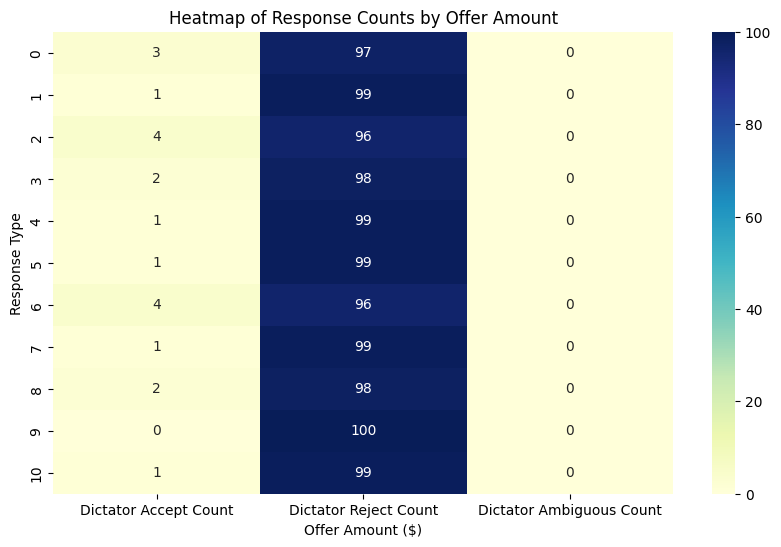

Experiment Cost: $0.046603000000000214 




In [ ]:
heatmap_responses(results_df)
print(f"Experiment Cost: ${cost} \n\n")

In [ ]:
#
results_df, cost = await DG_main(TSIMANE,
                                 game="DG",
                                 tribename="Tsimane")

# write results to spreadsheet
tsimane_DG_counts = results_df.groupby('Offer Amount').sum()
print(f"Total Acceptances (below 5): {tsimane_DG_counts[tsimane_DG_counts.index < 6]['Dictator Accept Count'].sum()}")
tsimane_DG_counts.to_csv("/content/ResponsesCounts/DG_experiment_counts_Tsimane.csv")


Experiment completed in 214.16 seconds.
Total Experiment Cost: 0.04607400000000014
Total Acceptances (below 5): 18


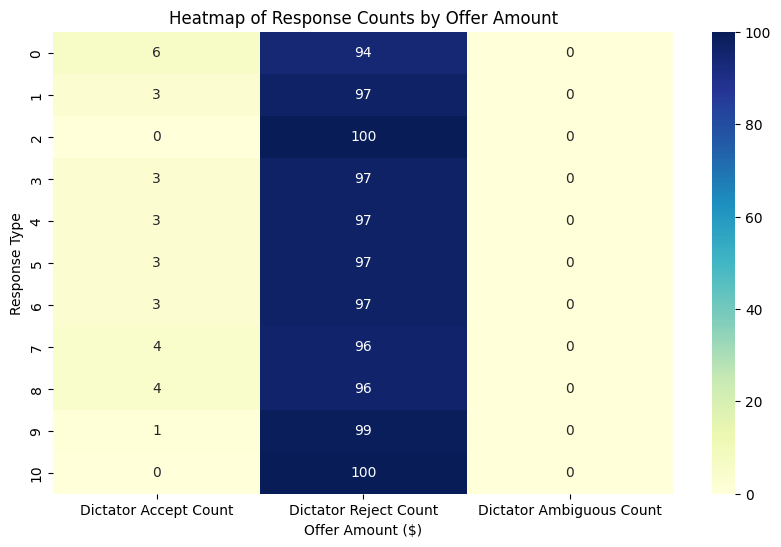

Experiment Cost: $0.04607400000000014 




In [ ]:
heatmap_responses(results_df)
print(f"Experiment Cost: ${cost} \n\n")

In [ ]:
#
results_df, cost = await DG_main(ORMA,
                                 game="DG",
                                 tribename="Orma")

# write results to spreadsheet
orma_DG_counts = results_df.groupby('Offer Amount').sum()
print(f"Total Acceptances (below 5): {orma_DG_counts[orma_DG_counts.index < 6]['Dictator Accept Count'].sum()}")
orma_DG_counts.to_csv("/content/ResponsesCounts/DG_experiment_counts_Orma.csv")


Experiment completed in 212.89 seconds.
Total Experiment Cost: 0.04785400000000053
Total Acceptances (below 5): 29


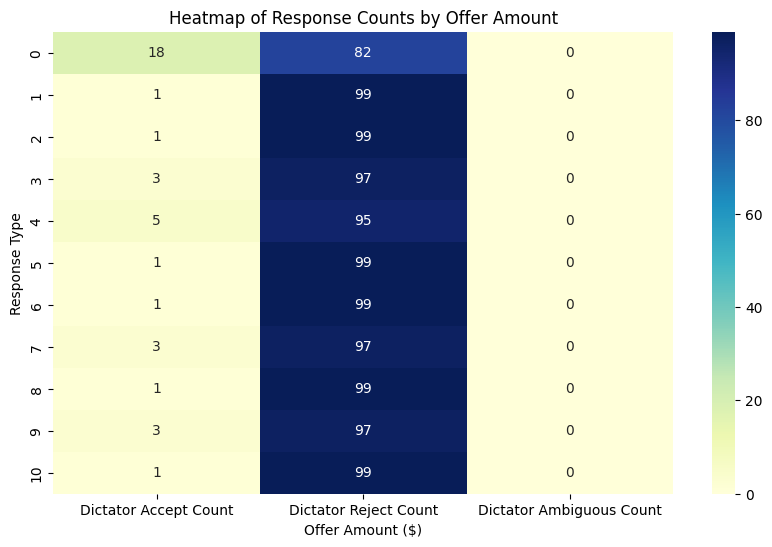

Experiment Cost: $0.04785400000000053 




In [ ]:
heatmap_responses(results_df)
print(f"Experiment Cost: ${cost} \n\n")

In [ ]:
#
results_df, cost = await DG_main(YANOMAMI,
                                 game="DG",
                                 tribename="Yanomami")

# write results to spreadsheet
yanomami_DG_counts = results_df.groupby('Offer Amount').sum()
print(f"Total Acceptances (below 5): {yanomami_DG_counts[yanomami_DG_counts.index < 6]['Dictator Accept Count'].sum()}")
yanomami_DG_counts.to_csv("/content/ResponsesCounts/DG_experiment_counts_Yanomami.csv")


Experiment completed in 216.30 seconds.
Total Experiment Cost: 0.04550999999999994
Total Acceptances (below 5): 2


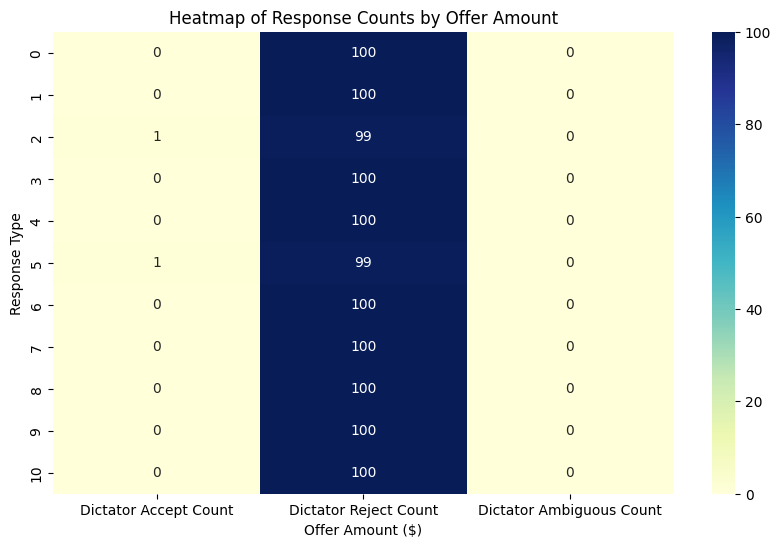

Experiment Cost: $0.04550999999999994 




In [ ]:
heatmap_responses(results_df)
print(f"Experiment Cost: ${cost} \n\n")

In [ ]:
#
results_df, cost = await DG_main(MACHIGUENGA,
                                 game="DG",
                                 tribename="Machiguenga")

# write results to spreadsheet
machiguenga_DG_counts = results_df.groupby('Offer Amount').sum()
print(f"Total Acceptances (below 5): {machiguenga_DG_counts[machiguenga_DG_counts.index < 6]['Dictator Accept Count'].sum()}")
machiguenga_DG_counts.to_csv("/content/ResponsesCounts/DG_experiment_counts_Machiguenga.csv")


Experiment completed in 210.33 seconds.
Total Experiment Cost: 0.04500699999999977
Total Acceptances (below 5): 42


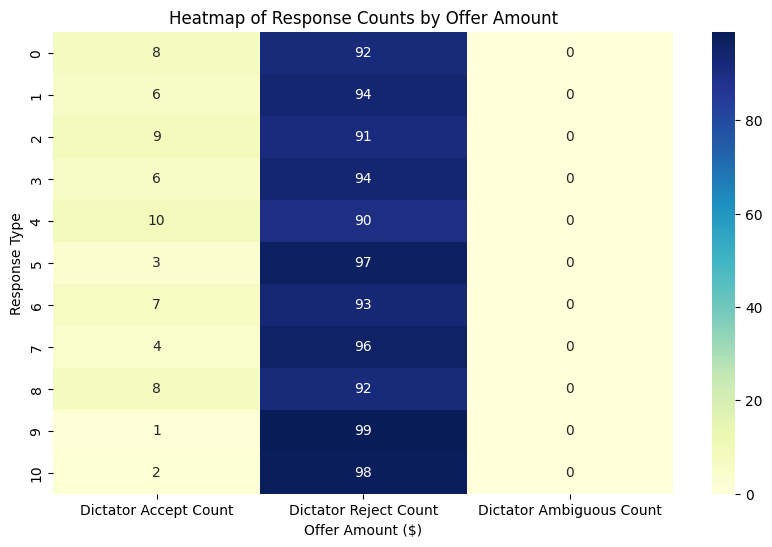

Experiment Cost: $0.04500699999999977 




In [ ]:
heatmap_responses(results_df)
print(f"Experiment Cost: ${cost} \n\n")

In [ ]:
#
results_df, cost = await DG_main("",
                                 game="DG",
                                 tribename="ChatGPT3")

# write results to spreadsheet
chatgpt3_DG_counts = results_df.groupby('Offer Amount').sum()
print(f"Total Acceptances (below 5): {chatgpt3_DG_counts[chatgpt3_DG_counts.index < 6]['Dictator Accept Count'].sum()}")
chatgpt3_DG_counts.to_csv("/content/ResponsesCounts/DG_experiment_counts_ChatGPT3.csv")


Experiment completed in 210.36 seconds.
Total Experiment Cost: 0.0467440000000003
Total Acceptances (below 5): 26


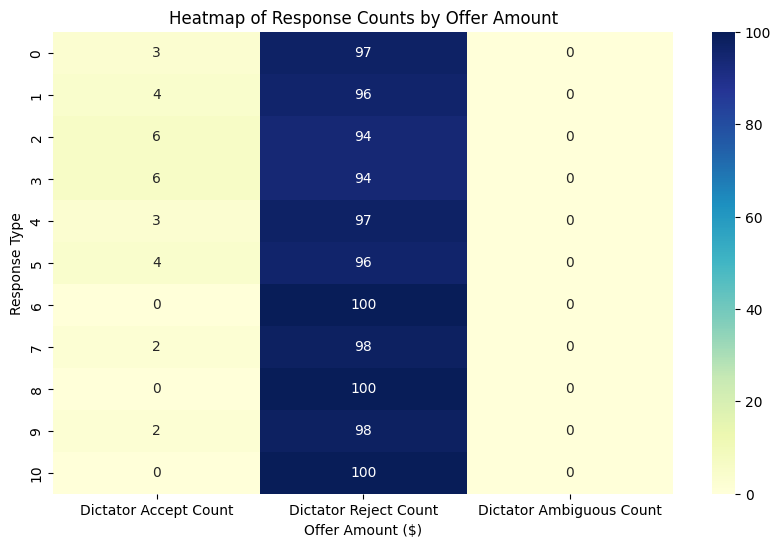

Experiment Cost: $0.0467440000000003 




In [ ]:
heatmap_responses(results_df)
print(f"Experiment Cost: ${cost} \n\n")

Code below was also used to created the zipped folders for responses and counts using GPTP 4o generated profiles.

In [ ]:
!zip -r /content/Responses_Claude3P_FullRange.zip /content/Responses

  adding: content/Responses/ (stored 0%)
  adding: content/Responses/ChatGPT3-DG.json (deflated 86%)
  adding: content/Responses/Yanomami-DG.json (deflated 90%)
  adding: content/Responses/Tsimane-DG.json (deflated 89%)
  adding: content/Responses/Orma-DG.json (deflated 88%)
  adding: content/Responses/Ache-DG.json (deflated 89%)
  adding: content/Responses/Hazda-DG.json (deflated 89%)
  adding: content/Responses/Machiguenga-DG.json (deflated 89%)


In [ ]:
!zip -r /content/ResponsesCounts_Claude3P_FullRange.zip /content/ResponsesCounts

  adding: content/ResponsesCounts/ (stored 0%)
  adding: content/ResponsesCounts/DG_experiment_counts_Tsimane.csv (deflated 41%)
  adding: content/ResponsesCounts/DG_experiment_counts_Hazda.csv (deflated 40%)
  adding: content/ResponsesCounts/DG_experiment_counts_Ache.csv (deflated 47%)
  adding: content/ResponsesCounts/DG_experiment_counts_Yanomami.csv (deflated 51%)
  adding: content/ResponsesCounts/DG_experiment_counts_Machiguenga.csv (deflated 35%)
  adding: content/ResponsesCounts/DG_experiment_counts_Orma.csv (deflated 43%)
  adding: content/ResponsesCounts/DG_experiment_counts_ChatGPT3.csv (deflated 41%)


## Ultimatum Game

In [ ]:
def generate_UG_prompt(proposer: bool,
                       profile: str = "",
                       amount_endowed: int = 10,
                       offer_percentage: float = None) -> str:
    """
    Generates game and task prompts for either the proposer or responder,
    requesting a binary decision followed by a brief justification.

    :param proposer: True if the agent is the proposer, False if the agent is the responder.
    :param amount_endowed: The total amount to be distributed.
    :param offer_precentage: The percentage of the total amount the proposer is considering to offer.
    :return: A string containing the generated prompt.
    """

    system_prompt = ""

    if len(profile) > 10:
        system_prompt = f"""You are a member of a tribe with the following characteristics.
                You must answer as if you were a representative member of such tribe.

                -----
                {profile}

                -----

                You and other members of the same tribe have been selected to participate in an experiment.

            """
    else:
        system_prompt = "You are a helpful assistant that has been randomly selected to participate in an experiment."

    # tribe members play against other 'tribe member', Vainilla GPT plays against another 'player'
    if proposer:
        return system_prompt + "\n\n\n" + (f"You have been chosen to be a proposer of an offer to distribute ${amount_endowed},"
                f"which is equal to a day's worth of work, between yourself and another {'tribe member' if len(profile) > 10 else 'player'} whose identity is not disclosed. "
                f"If the other {'tribe member' if len(profile) > 10 else 'player'} accepts the offer, you keep the difference between ${amount_endowed} and your offer. "
                f"If the other {'tribe member' if len(profile) > 10 else 'player'} rejects the offer, you and the other {'tribe member' if len(profile) > 10 else 'player'} get nothing. "
                f"Offering exactly $5 represents an equal split."
                f"\n\nGiven this, would you offer ${offer_percentage} out of ${amount_endowed}?"
                f"You must answer 'Yes' or 'No'.."
                "Start with your answer, followed by a separator token [EXP], and then briefly justify your reasoning step by step.")
    else:
        return system_prompt + "\n\n\n" + (f"You have been chosen to be a recipient of an offer from another {'tribe member' if len(profile) > 10 else 'player'} whose identity is not disclosed. "
                f"The proposer was chosen to distribute ${amount_endowed} between the proposer and you."
                f"You can either accept or reject this offer. "
                f"If you accept the offer, you get what is proposed and the proposer gets the difference between ${amount_endowed} and the offer."
                f"If you reject the offer, you and the other get nothing."
                f"An offer of exactly $5 represents an equal split."
                f"\n\nYou are offered ${offer_percentage} out of ${amount_endowed}. "
                f"Do you accept this offer? You must answer 'Yes' or 'No'."
                "Start with your answer, followed by a separator token [EXP], and then briefly justify your reasoning step by step.")


In [ ]:
def post_experiment_processing(organized_results, engine,
                               save_path="experiment_responses.txt"):
    total_costs = []
    all_data = []

    for offer_percentage, responses in organized_results.items():
        for proposer_response, responder_response in responses:
            game_cost = compute_cost(len(proposer_response) + len(responder_response), engine)
            total_costs.append(game_cost)

            proposer_counts = count_responses(proposer_response, prefix="Proposer")
            responder_counts = count_responses(responder_response, prefix="Responder")

            data_entry = {
                'Offer Percentage': offer_percentage,
                **proposer_counts,
                **responder_counts,
            }
            all_data.append(data_entry)

    experiment_cost = sum(total_costs)
    print(f"Total Experiment Cost: {experiment_cost}")

    # Save responses to file
    with open(save_path, "w") as file:
        json.dump(organized_results, file)

    return pd.DataFrame(all_data), experiment_cost

async def simulate_offer_responses_async(executor, llm, profile,
                                         amount_endowed, offer_percentage):
    loop = asyncio.get_event_loop()

    # if profile is longer than 10 character we use custom system prompt
    # else use default openai prompt
    proposer_prompt = generate_UG_prompt(True, profile, amount_endowed, offer_percentage)
    responder_prompt = generate_UG_prompt(False, profile, amount_endowed, offer_percentage)

    # Run the synchronous .invoke method in a thread pool
    proposer_response = await loop.run_in_executor(executor, llm.invoke, proposer_prompt)
    responder_response = await loop.run_in_executor(executor, llm.invoke, responder_prompt)

    return proposer_response.content, responder_response.content

async def run_experiment(executor, llm, profile, amount_endowed,
                         offer_percentages, num_runs):

    start_time = time.time()
    organized_results = {percentage: [] for percentage in offer_percentages}

    for offer_percentage in offer_percentages:
        responses = await simulate_and_collect_responses(executor, llm, profile,
                                                         amount_endowed, offer_percentage,
                                                         num_runs)
        organized_results[offer_percentage].extend(responses)

    elapsed_time = time.time() - start_time
    print(f"Experiment completed in {elapsed_time:.2f} seconds.")

    return organized_results

async def simulate_and_collect_responses(executor, llm, profile, amount_endowed,
                                         offer_percentage, num_runs):
    # Assuming this function is similar to `simulate_offer_responses_async` but adjusted for batch collection
    tasks = [simulate_offer_responses_async(executor, llm, profile,
                                            amount_endowed, offer_percentage) for _ in range(num_runs)]

    responses = await asyncio.gather(*tasks)
    return responses

In [ ]:
def plot_comparison(results, tribe):
    """
    Plots a comparison of accept, reject, and ambiguous response counts for proposers and responders across offer percentages,
    using two subplots for clear distinction between proposer and responder data.

    Parameters:
    - results (pandas.DataFrame): DataFrame containing the experiment results.
    """
    results = pd.DataFrame(results)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))  # Increase figure size to accommodate two subplots

    # Number of groups and bar width
    n_groups = len(results)
    index = np.arange(n_groups)
    bar_width = 0.25  # Wider bar width for clarity in separate plots

    # Proposer counts plot on ax1
    ax1.bar(index - bar_width, results['Proposer Accept Count'], bar_width, color='green', label='Yes')
    ax1.bar(index, results['Proposer Reject Count'], bar_width, color='red', label='No')
    ax1.bar(index + bar_width, results['Proposer Ambiguous Count'], bar_width, color='gray', label='Ambiguous')

    # Responder counts plot on ax2
    ax2.bar(index - bar_width, results['Responder Accept Count'], bar_width, color='lightgreen', label='Yes')
    ax2.bar(index, results['Responder Reject Count'], bar_width, color='lightcoral', label='No')
    ax2.bar(index + bar_width, results['Responder Ambiguous Count'], bar_width, color='lightgray', label='Ambiguous')

    # Setting labels, titles, and legends for each subplot
    ax1.set_xlabel('Offer Amount')
    ax1.set_ylabel('Counts')
    ax1.set_title('Proposer Response Counts by Offer Amount')
    ax1.set_xticks(index)
    ax1.set_xticklabels(results.index)
    ax1.legend()

    ax2.set_xlabel('Offer Amount')
    ax2.set_ylabel('Counts')
    ax2.set_title(f'Responder Response Counts ({tribe}) by Offer Amount')
    ax2.set_xticks(index)
    ax2.set_xticklabels(results.index)
    ax2.legend()

    # Improving layout to prevent label overlap
    plt.tight_layout()

    # Show plot
    plt.show()

In [ ]:
async def UG_main(profile,
                  engine,
                  save_file_path):
    '''
    Run 100 experiments of the ultimatum game for each offer percentage

    inputs:
        profile (str): The cultural profile
        save-file_path (str): Path where to save the full responses
    outputs:
        df (pd.DataFrame): Dataframe with results
        cost (float): Estimated cost of experiment
    '''
    executor = ThreadPoolExecutor()

    llm = load_llm(engine,
                   profile=profile)

    amount_endowed = 10  # day's worth of work
    offer_percentages = list(range(0, 11, 1)) # Percentages to experiment with

    organized_results = await run_experiment(
            executor=executor,
            llm=llm,
            profile=profile,
            amount_endowed=amount_endowed,
            offer_percentages=offer_percentages,
            num_runs=100
        )

    df, cost = post_experiment_processing(organized_results, engine,
                                          save_path=save_file_path)
    return df, cost


Experiment completed in 462.50 seconds.
Total Experiment Cost: 0.5021099999999995


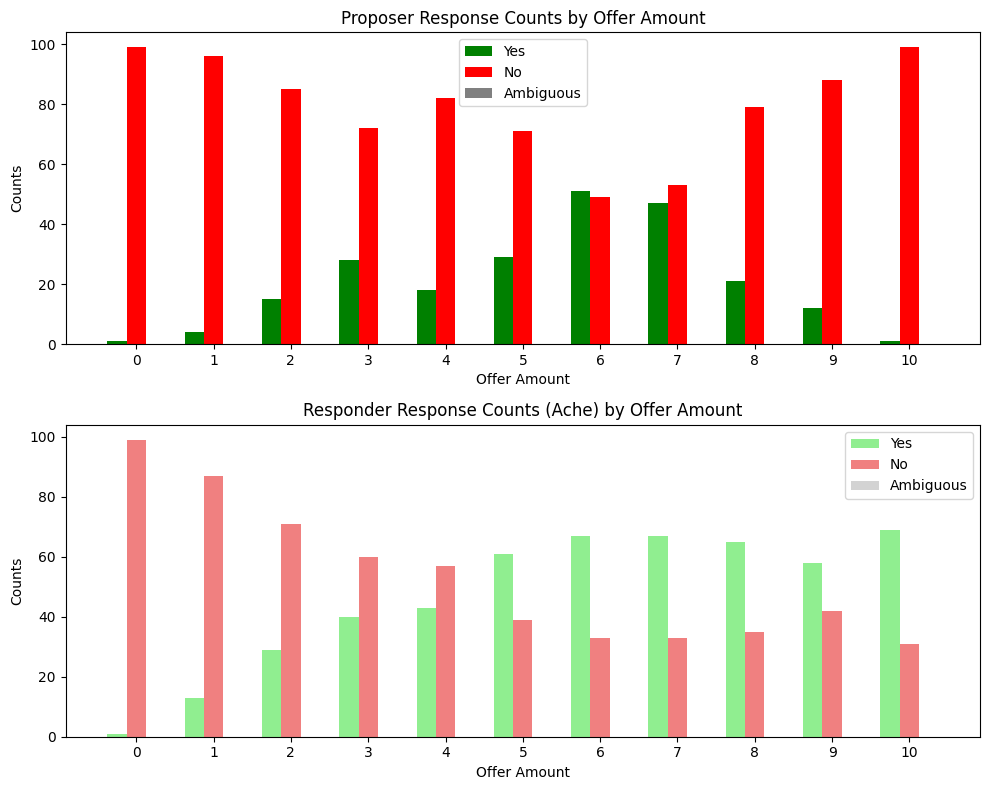

Experiment completed in 486.81 seconds.
Total Experiment Cost: 0.49715799999999954


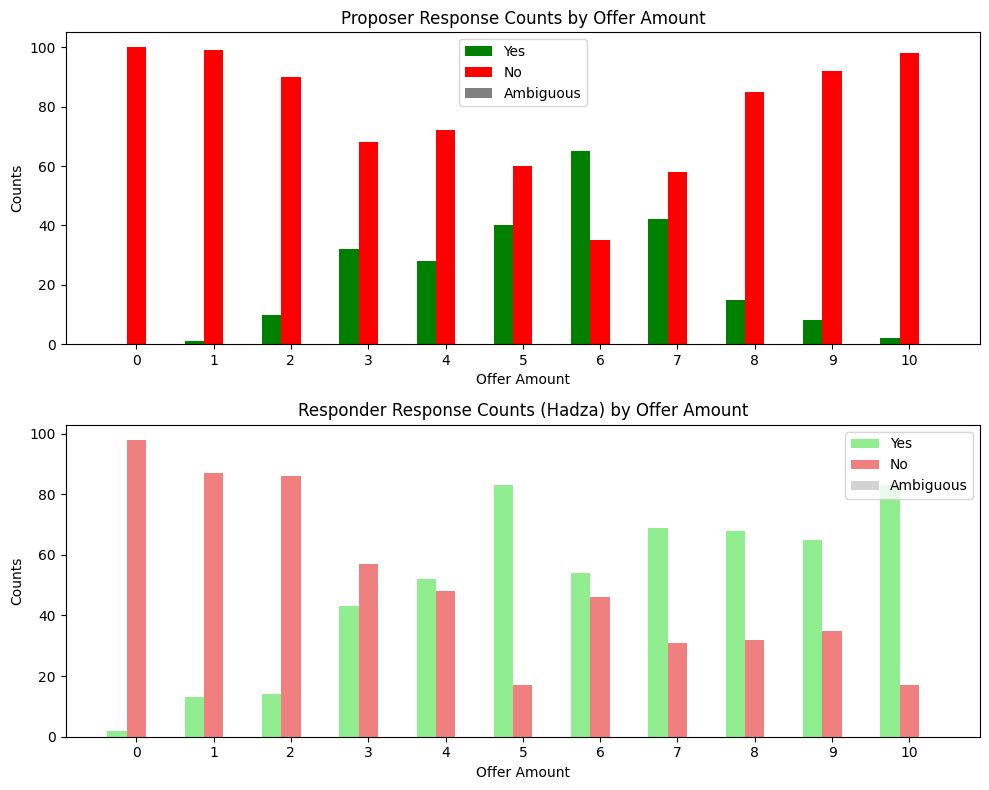

Experiment completed in 466.44 seconds.
Total Experiment Cost: 0.5044809999999995


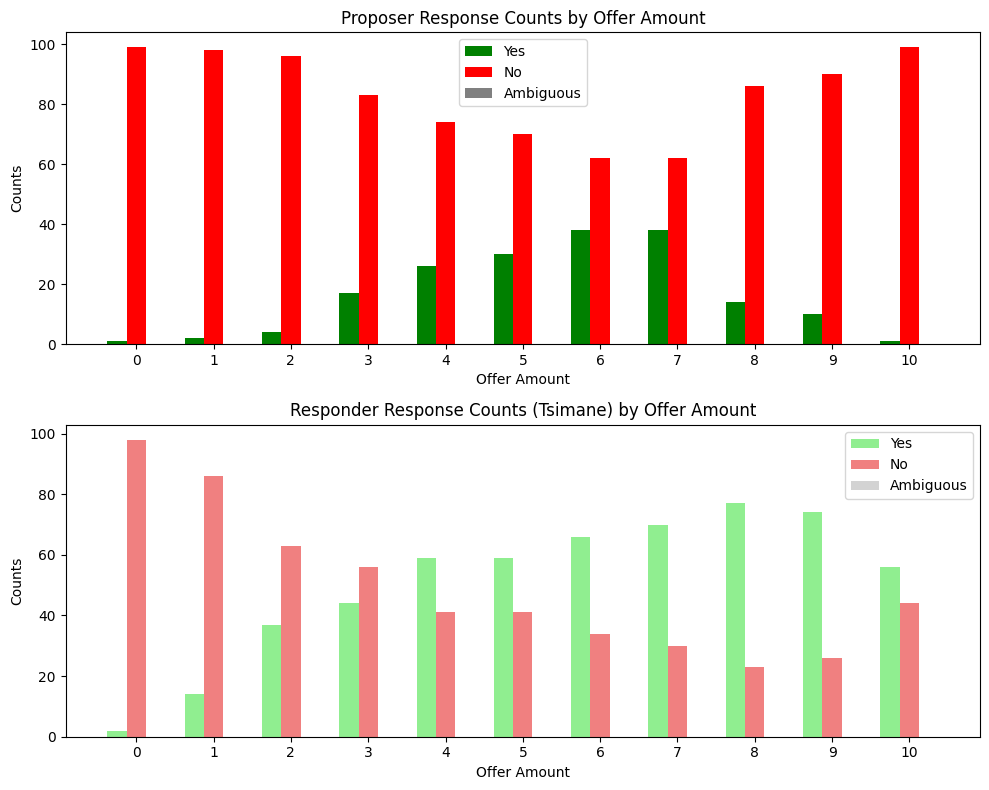

Experiment completed in 462.47 seconds.
Total Experiment Cost: 0.49925


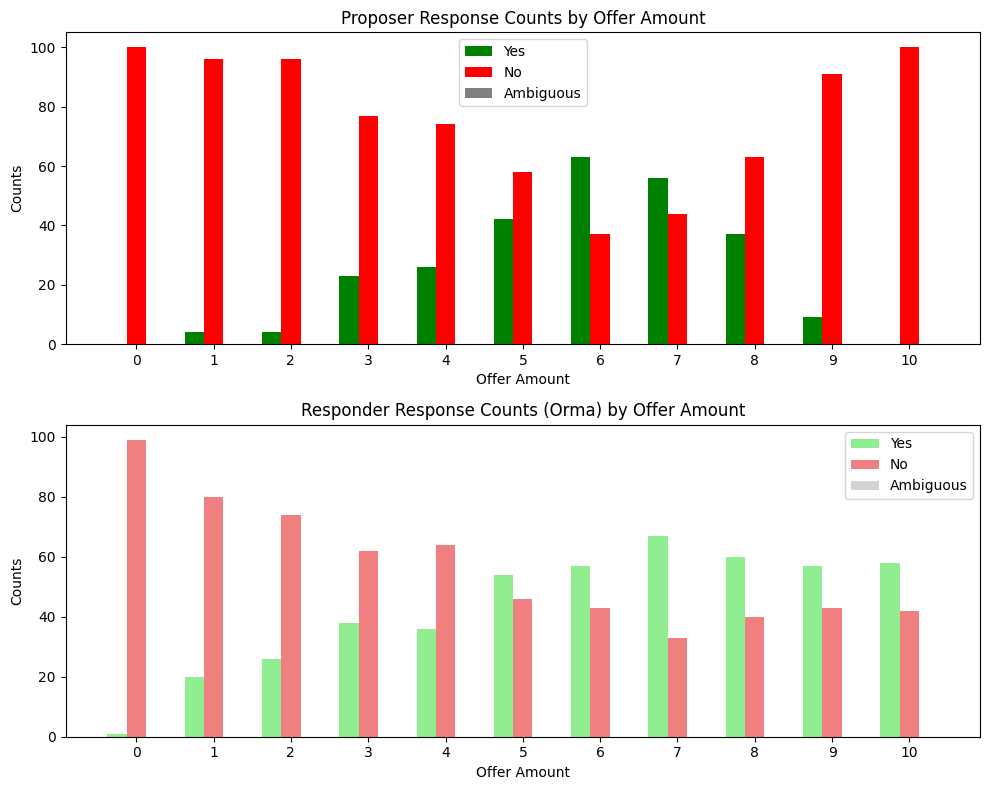

Experiment completed in 483.32 seconds.
Total Experiment Cost: 0.49822399999999983


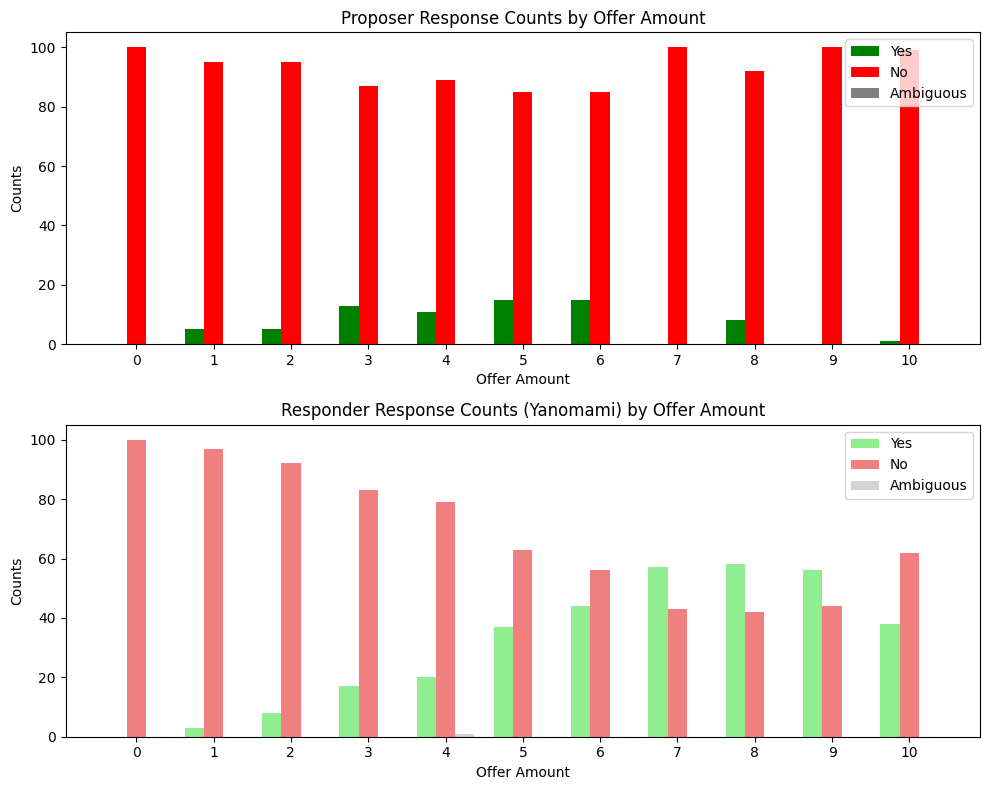

Experiment completed in 478.84 seconds.
Total Experiment Cost: 0.5047739999999998


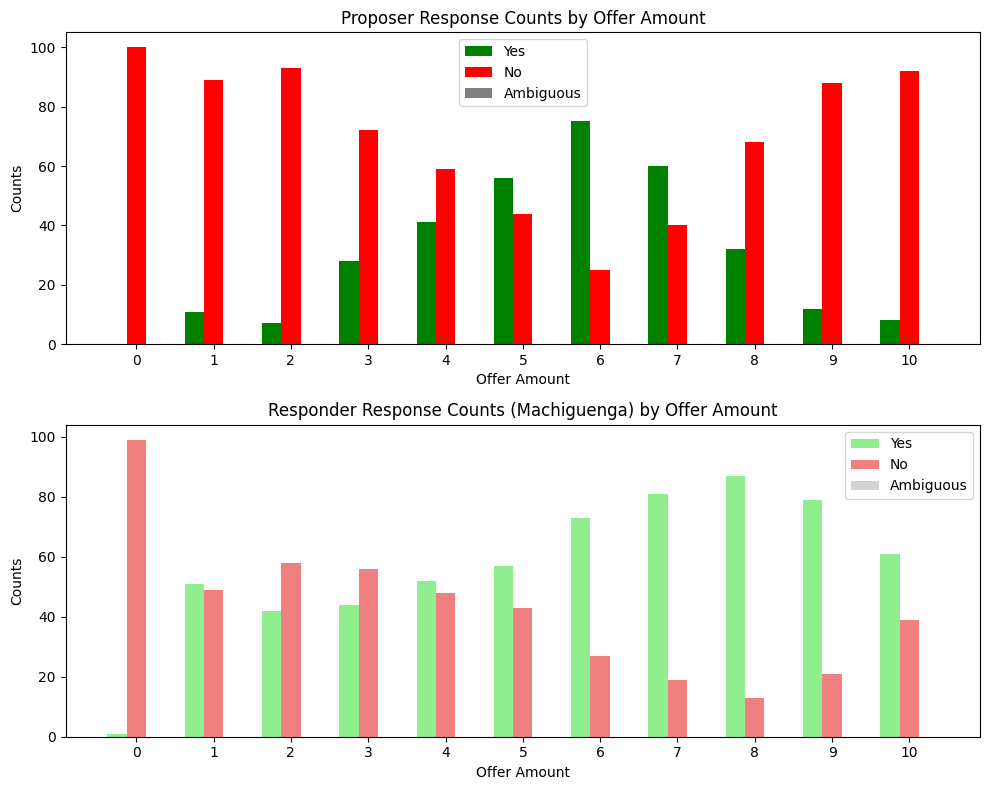

In [ ]:
# Run UG experiment for each tribe profile
engine = "gpt-3.5-turbo"

i = 0
for profile in profiles:
    results_df, cost = await UG_main(profile, engine,
                                     f"/content/Responses/UG_experiment_responses_{NAMES[i]}.txt")

    tribe_UG_counts = results_df.groupby("Offer Percentage").sum()
    tribe_UG_counts.to_csv(f"/content/ResponsesCounts/UG_experiment_counts_{NAMES[i]}.csv")

    plot_comparison(tribe_UG_counts,
                    NAMES[i])

    i += 1

Experiment completed in 441.17 seconds.
Total Experiment Cost: 0.4858610000000001


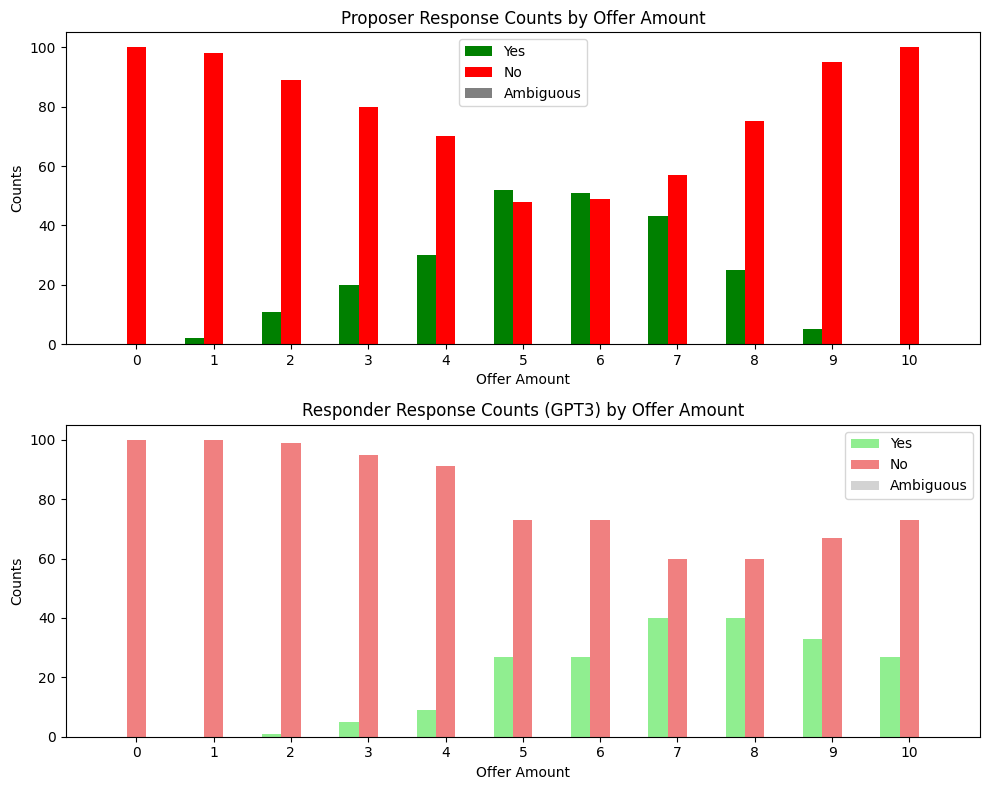

In [ ]:
# Run UG experiment for each tribe profile
engine = "gpt-3.5-turbo"

results_df, cost = await UG_main("", engine,
                                 f"UG_experiment_responses_GPT3.txt")

tribe_UG_counts = results_df.groupby("Offer Percentage").sum()
tribe_UG_counts.to_csv(f"UG_experiment_counts_GPT3.csv")

plot_comparison(tribe_UG_counts,
                "GPT3")

In [ ]:
!zip -r /content/Responses_GPT4oP_UG.zip /content/Responses

  adding: content/Responses/ (stored 0%)
  adding: content/Responses/UG_experiment_responses_Machiguenga.txt (deflated 89%)
  adding: content/Responses/UG_experiment_responses_Orma.txt (deflated 88%)
  adding: content/Responses/UG_experiment_responses_Tsimane.txt (deflated 89%)
  adding: content/Responses/UG_experiment_responses_Yanomami.txt (deflated 90%)
  adding: content/Responses/UG_experiment_responses_Ache.txt (deflated 89%)
  adding: content/Responses/UG_experiment_responses_Hadza.txt (deflated 89%)


In [ ]:
!zip -r /content/ResponsesCounts_GPT4oP_UG.zip /content/ResponsesCounts

  adding: content/ResponsesCounts/ (stored 0%)
  adding: content/ResponsesCounts/UG_experiment_counts_Tsimane.csv (deflated 49%)
  adding: content/ResponsesCounts/UG_experiment_counts_Orma.csv (deflated 49%)
  adding: content/ResponsesCounts/UG_experiment_counts_Ache.csv (deflated 48%)
  adding: content/ResponsesCounts/UG_experiment_counts_Machiguenga.csv (deflated 47%)
  adding: content/ResponsesCounts/UG_experiment_counts_Yanomami.csv (deflated 50%)
  adding: content/ResponsesCounts/UG_experiment_counts_Hadza.csv (deflated 48%)
